#Cek GPU

In [2]:
!nvidia-smi

Wed Mar 19 09:20:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Install Library yang Dibutuhkan

In [3]:
!pip install segmentation_models_pytorch --quiet
!pip install albumentations --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

segmentation_models_pytorch (SMP) = untuk DeepLabV3+</br>
albumentations = untuk augmentasi yang efisien.

#Download Dataset

In [4]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


In [5]:
# Download the dataset
!wget https://github.com/cwfid/dataset/archive/v1.0.tar.gz
!tar -zxf v1.0.tar.gz
pardir = "dataset-1.0"

--2025-03-19 09:22:09--  https://github.com/cwfid/dataset/archive/v1.0.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/cwfid/dataset/tar.gz/refs/tags/v1.0 [following]
--2025-03-19 09:22:10--  https://codeload.github.com/cwfid/dataset/tar.gz/refs/tags/v1.0
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.tar.gz’

v1.0.tar.gz             [            <=>     ]  86.12M  17.8MB/s    in 4.9s    

2025-03-19 09:22:15 (17.7 MB/s) - ‘v1.0.tar.gz’ saved [90303402]



In [6]:
import os

pardir = "dataset-1.0"

# List gambar dan mask
print("Images Folder:", os.listdir(os.path.join(pardir, "images"))[:5])
print("Masks Folder:", os.listdir(os.path.join(pardir, "annotations"))[:5])


Images Folder: ['057_image.png', '007_image.png', '056_image.png', '030_image.png', '011_image.png']
Masks Folder: ['047_annotation.png', '024_annotation.yaml', '048_annotation.yaml', '010_annotation.yaml', '009_annotation.png']


In [7]:
from PIL import Image
import numpy as np

mask_path = '/content/dataset-1.0/annotations/001_annotation.png'

mask = Image.open(mask_path)
mask_np = np.array(mask)

print("Mask shape:", mask_np.shape)
print("Unique pixel values (classes):", np.unique(mask_np))


Mask shape: (966, 1296, 3)
Unique pixel values (classes): [  0 255]


In [8]:
def convert_rgb_mask_to_label(mask_rgb):
    """
    Convert RGB mask (H, W, 3) → label mask (H, W)
    Black (0,0,0) → 0 (background)
    Green (0,255,0) → 1 (crop)
    Red (255,0,0) → 2 (weed)
    """
    label_mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)

    background = np.all(mask_rgb == [0, 0, 0], axis=-1)
    crop = np.all(mask_rgb == [0, 255, 0], axis=-1)
    weed = np.all(mask_rgb == [255, 0, 0], axis=-1)

    label_mask[background] = 0
    label_mask[crop] = 1
    label_mask[weed] = 2

    return label_mask


#Fungsi Visualisasi Gambar + Mask Asli

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [10]:
def visualize_image_and_mask(image_path, mask_path, class_colors=None):
    # Load image
    img = Image.open(image_path).convert("RGB")

    # Load dan convert mask ke label jika perlu
    mask_rgb = Image.open(mask_path).convert("RGB")
    mask_np = np.array(mask_rgb)

    # Convert RGB mask → label mask
    label_mask = convert_rgb_mask_to_label(mask_np)

    # Create color mask
    color_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    for cls, color in class_colors.items():
        mask_idx = label_mask == cls
        color_mask[mask_idx, 0] = color[0]
        color_mask[mask_idx, 1] = color[1]
        color_mask[mask_idx, 2] = color[2]

    # Plot hasil
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title('Ground Truth Mask (Colored)')

    plt.axis('off')
    plt.show()


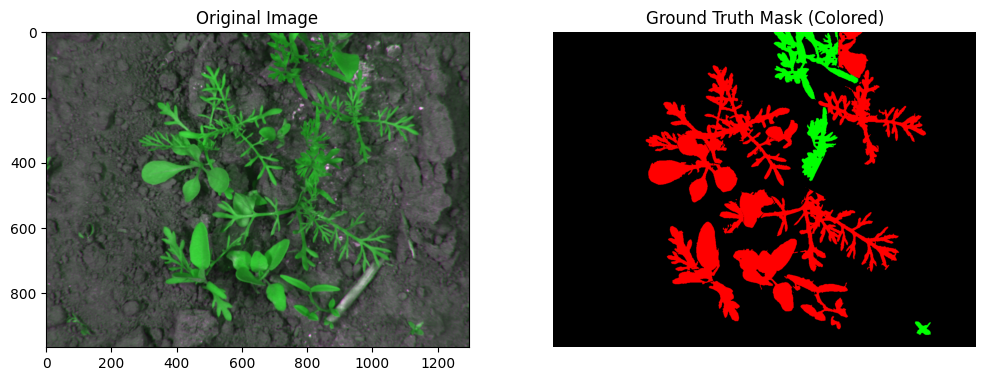

In [11]:
image_path = '/content/dataset-1.0/images/001_image.png'
mask_path = '/content/dataset-1.0/annotations/001_annotation.png'

visualize_image_and_mask(image_path, mask_path)



In [12]:
print(np.unique(mask_np))

[  0 255]


#Patching Dataset (Dataloader)

In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch


In [14]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CWFIDPatchDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, stride=256, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # ✅ Filter hanya file gambar yang diinginkan
        valid_ext = ['.png', '.jpg', '.jpeg']

        self.image_paths = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.mask_paths = sorted([
            os.path.join(mask_dir, f)
            for f in os.listdir(mask_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.patches = self.create_patch_index()

    def create_patch_index(self):
        patch_list = []
        for idx, img_path in enumerate(self.image_paths):
            img = Image.open(img_path)
            w, h = img.size
            for y in range(0, h - self.patch_size + 1, self.stride):
                for x in range(0, w - self.patch_size + 1, self.stride):
                    patch_list.append((idx, x, y))
        return patch_list

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, index):
        idx, x, y = self.patches[index]

        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")  # convert RGB biar aman ke label mask

        img_patch = img.crop((x, y, x + self.patch_size, y + self.patch_size))
        mask_patch = mask.crop((x, y, x + self.patch_size, y + self.patch_size))

        # Convert mask ke label di sini (jika perlu), atau lakukan di transform
        mask_patch = np.array(mask_patch)
        mask_patch = convert_rgb_mask_to_label(mask_patch)

        if self.transform:
            augmented = self.transform(image=np.array(img_patch), mask=mask_patch)
            img_patch = augmented['image']
            mask_patch = augmented['mask']

        return img_patch, torch.as_tensor(mask_patch, dtype=torch.long)


#Transformasi & Augmentasi (Albumentations)

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(512, 512, p=1.0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
    ])


#Fungsi buat cek loader & augmentasi:

In [16]:
def visualize_dataset_sample(dataset, index=0, class_colors=None):
    # Ambil sample dari dataset
    img_patch, mask_patch = dataset[index]

    # Convert Tensor ke numpy array
    img_np = img_patch.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = (img_np * 0.5 + 0.5)  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    # Convert mask ke numpy array
    mask_np = mask_patch.cpu().numpy()

    # FIX: Mask RGB → Label mask
    if mask_np.ndim == 3 and mask_np.shape[2] == 3:
        print("Converting RGB mask to label mask...")
        mask_np = convert_rgb_mask_to_label(mask_np)

    # Buat canvas warna mask
    color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    for cls, color in class_colors.items():
        mask_idx = mask_np == cls
        color_mask[mask_idx] = color

    # Overlay mask di atas gambar
    def overlay_mask_on_image(image, mask, alpha=0.4):
        return np.clip((1 - alpha) * image + alpha * (mask / 255.0), 0, 1)

    overlay = overlay_mask_on_image(img_np, color_mask)

    # Plot semua hasil
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title(f'Patch Image #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f'Label Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_mask)
    plt.title(f'Colored Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title(f'Overlay Patch + Mask #{index}')
    plt.axis('off')

    plt.show()


#Load Dataset

In [17]:
# Sesuaikan path folder
image_dir = '/content/dataset-1.0/images'
mask_dir = '/content/dataset-1.0/annotations'

In [18]:
# Buat dataset patch on-the-fly
dataset = CWFIDPatchDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    patch_size=512,
    stride=256,
    transform=train_transform  # augmentasi dasar
)

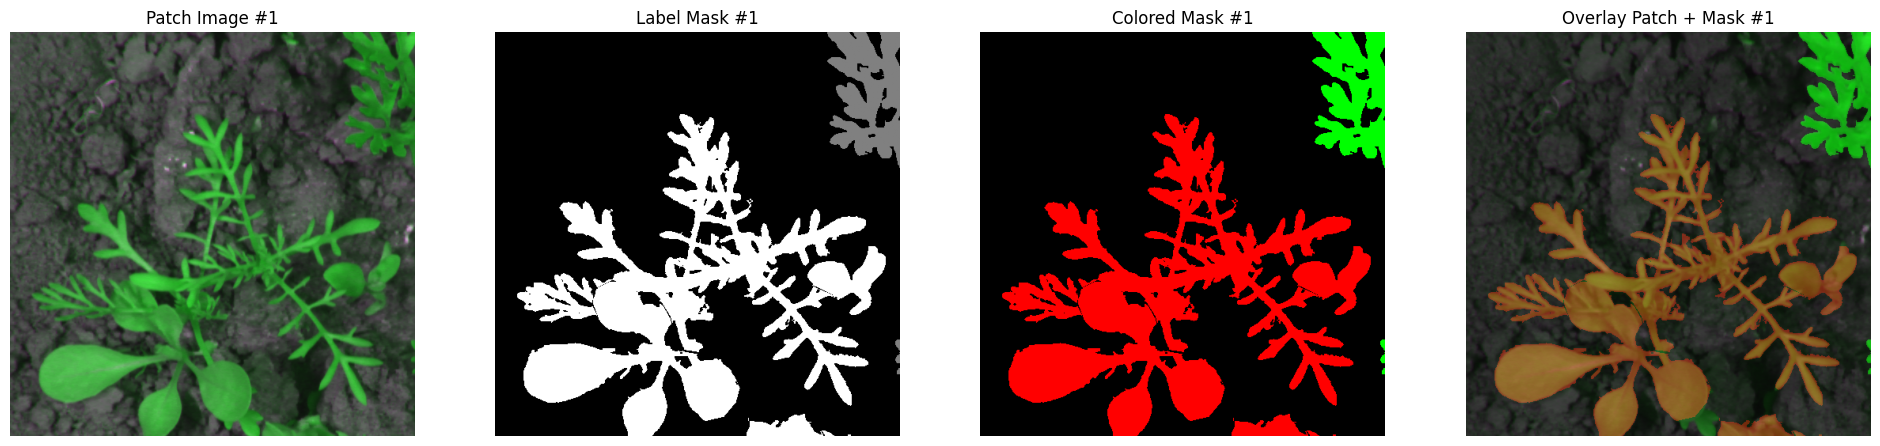

In [19]:
# Dari dataset patch loader (on-the-fly)
visualize_dataset_sample(dataset, index=1)


#Dataset Split

In [20]:
from torch.utils.data import Subset
import numpy as np

import numpy as np
from torch.utils.data import Subset

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True):
    # FIX: Handle floating point precision!
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Total split ratio must be 1.0"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    if shuffle:
        np.random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)
    val_end = train_end + int(val_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    print(f"Total Patches: {dataset_size}")
    print(f"Train Set  : {len(train_dataset)} patches ({train_ratio*100}%)")
    print(f"Valid Set  : {len(val_dataset)} patches ({val_ratio*100}%)")
    print(f"Test Set   : {len(test_dataset)} patches ({test_ratio*100}%)")

    return train_dataset, val_dataset, test_dataset


#Setup DeepLabV3+ (Guru Model) dengan Mixed Precision

In [21]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# DeepLabV3+ dengan EfficientNet-B4 backbone
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
).cuda()

# Loss Function
dice_loss = smp.losses.DiceLoss(mode='multiclass')
focal_loss = smp.losses.FocalLoss(mode='multiclass')

def total_loss(pred, target):
    return dice_loss(pred, target) + focal_loss(pred, target)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 415MB/s]


In [22]:
!pip install torchinfo


In [23]:
from torchinfo import summary

# Pastikan model di GPU / CPU
model = model.cuda()  # atau .cpu() sesuai device

# Tampilkan summary, contoh input shape: (batch_size, channels, height, width)
summary(model, input_size=(1, 3, 512, 512))


Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           [1, 3, 512, 512]          --
├─EfficientNetEncoder: 1-1                              [1, 3, 512, 512]          806,400
│    └─Conv2dStaticSamePadding: 2-1                     [1, 48, 256, 256]         1,296
│    │    └─ZeroPad2d: 3-1                              [1, 3, 513, 513]          --
│    └─BatchNorm2d: 2-2                                 [1, 48, 256, 256]         96
│    └─MemoryEfficientSwish: 2-3                        [1, 48, 256, 256]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [1, 24, 256, 256]         2,940
│    │    └─MBConvBlock: 3-3                            [1, 24, 256, 256]         1,206
│    │    └─MBConvBlock: 3-4                            [1, 32, 128, 128]         11,878
│    │    └─MBConvBlock: 3-5              

In [24]:
model_summary = summary(model, input_size=(1, 3, 512, 512))
with open('/content/drive/MyDrive/colab_indra/ss/cwfid_new/02/model_summary.txt', 'w') as f:
    f.write(str(model_summary))


#Mixed Precision Training Loop

In [25]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# DeepLabV3+ dengan EfficientNet-B4 backbone
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
).cuda()

# Loss Function
dice_loss = smp.losses.DiceLoss(mode='multiclass')
focal_loss = smp.losses.FocalLoss(mode='multiclass')

def total_loss(pred, target):
    return dice_loss(pred, target) + focal_loss(pred, target)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


#Fungsi Evaluasi

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_metrics(outputs, masks, num_classes=3):
    """
    outputs: logits dari model, shape (B, C, H, W)
    masks: ground truth label, shape (B, H, W)
    """
    # Ambil prediksi kelas per pixel
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

    iou_list = []
    dice_list = []
    pixel_acc_list = []

    for cls in range(num_classes):
        tp = np.logical_and(preds == cls, masks == cls).sum()
        fp = np.logical_and(preds == cls, masks != cls).sum()
        fn = np.logical_and(preds != cls, masks == cls).sum()

        # IoU
        iou = tp / (tp + fp + fn + 1e-7)
        iou_list.append(iou)

        # Dice
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)
        dice_list.append(dice)

    # Pixel Accuracy
    pixel_acc = (preds == masks).sum() / np.prod(masks.shape)
    pixel_acc_list.append(pixel_acc)

    return np.mean(iou_list), np.mean(dice_list), np.mean(pixel_acc_list)


#Loop Evaluasi

In [27]:
def validate_epoch(loader, model):
    model.eval()
    iou_total, dice_total, acc_total = 0.0, 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.cuda(), masks.cuda()

            with autocast():
                outputs = model(imgs)

            iou, dice, acc = calculate_metrics(outputs, masks)
            iou_total += iou
            dice_total += dice
            acc_total += acc

    num_batches = len(loader)
    return iou_total / num_batches, dice_total / num_batches, acc_total / num_batches


 #EarlyStopping & ReduceLROnPlateau

In [28]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = -np.inf
        self.early_stop = False

    def __call__(self, val_iou):  # ← monitor val_iou
        if val_iou - self.best_score > self.min_delta:
            self.best_score = val_iou
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [29]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [30]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # maximize val_iou
    factor=0.5,           # Turunin LR jadi setengah
    patience=10,          # Kalau 10 epoch val_iou ga naik, LR diturunin
    threshold=1e-4,       # Toleransi perubahan (agar ga terlalu reaktif)
    min_lr=1e-6,          # Minimum LR biar ga 0
    verbose=True          # Print info kalau LR turun
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#Fungsi Evaluasi Metrics + Confusion Matrix (Training dan Validation)

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_metrics(model, loader, dataset_name='Dataset', num_classes=3, class_names=None):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with autocast():
                outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    # Flatten semua batch jadi 1 array
    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    # Hitung metrics
    precision = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_masks, all_preds, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Print hasil metrics
    print(f"📊 {dataset_name} Metrics:")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Optional: Plot Confusion Matrix
    if class_names:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{dataset_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return precision, recall, f1, cm


# Split Dataset train/val/test

In [32]:
# Split ke train/val/test
train_dataset, val_dataset, test_dataset = split_dataset(dataset, 0.7, 0.2, 0.1)

# Loader train
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Loader validasi
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Loader test
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Total Patches: 480
Train Set  : 336 patches (70.0%)
Valid Set  : 96 patches (20.0%)
Test Set   : 48 patches (10.0%)


#Training + Validation + EarlyStopping + Save Model Guru Terbaik

In [33]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_epoch(loader, model, optimizer):
    model.train()
    running_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()

        # Mixed Precision Training
        with autocast():
            outputs = model(imgs)

            # Hitung loss → sesuaikan dengan loss yang kamu pakai
            loss = total_loss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(loader)


<ipython-input-33-27281aed4cbc>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [34]:
def validate_epoch(loader, model):
    model.eval()
    iou_total, dice_total, acc_total = 0.0, 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with autocast():
                outputs = model(imgs)

            iou, dice, acc = calculate_metrics(outputs, masks)
            iou_total += iou
            dice_total += dice
            acc_total += acc

    num_batches = len(loader)
    return iou_total / num_batches, dice_total / num_batches, acc_total / num_batches


In [35]:
# Inisialisasi history buat logging metrics
history = {
    "train_loss": [],
    "val_iou": [],
    "val_dice": [],
    "val_acc": []
}

# Training loop
epochs = 500
best_val_iou = 0.0
best_val_dice= 0.0
early_stopper = EarlyStopping(patience=25, min_delta=1e-4)

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")

    # TRAINING
    train_loss = train_epoch(train_loader, model, optimizer)

    # VALIDATION
    val_iou, val_dice, val_acc = validate_epoch(val_loader, model)

    # Scheduler update
    scheduler.step(val_iou)

    # Logging learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.8f}")

    # Logging
    history["train_loss"].append(train_loss)
    history["val_iou"].append(val_iou)
    history["val_dice"].append(val_dice)
    history["val_acc"].append(val_acc)
    history.setdefault("lr", []).append(current_lr)

    # Print hasil
    print(f"Train Loss: {train_loss:.4f} | Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f} | Val Acc: {val_acc:.4f}")

    # Save guru model terbaik
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), 'best_guru_model_iou.pth')
        print("✅ Model Guru Terbaik Disimpan! (IoU Dice improved)")

    # Save best model berdasar val_dice (optional)
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_guru_model_dice.pth')
        print("✅ Guru Model disimpan! (Dice improved)")


    # Early stopping check
    early_stopper(val_iou)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered!")
        break



Epoch [1/500]


<ipython-input-33-27281aed4cbc>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-34-9a495bce8f18>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Learning Rate: 0.00010000
Train Loss: 0.9716 | Val IoU: 0.5657 | Val Dice: 0.6777 | Val Acc: 0.9222
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [2/500]
Learning Rate: 0.00010000
Train Loss: 0.5822 | Val IoU: 0.6525 | Val Dice: 0.7531 | Val Acc: 0.9532
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [3/500]
Learning Rate: 0.00010000
Train Loss: 0.3994 | Val IoU: 0.7597 | Val Dice: 0.8417 | Val Acc: 0.9703
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [4/500]
Learning Rate: 0.00010000
Train Loss: 0.2961 | Val IoU: 0.7887 | Val Dice: 0.8619 | Val Acc: 0.9769
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [5/500]
Learning Rate: 0.00010000
Train Loss: 0.2384 | Val IoU: 0.7888 | Val Dice: 0.8588 | Val Acc: 0.9792
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
Epoch [6/500]
Learning Rate: 0.00

In [43]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # Train Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], 'b', label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Validation IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["val_iou"], 'g', label='Validation IoU')
    plt.title('Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Validation Dice & Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["val_dice"], 'r', label='Validation Dice')
    plt.plot(epochs, history["val_acc"], 'm', label='Validation Pixel Acc')
    plt.title('Validation Dice & Pixel Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()


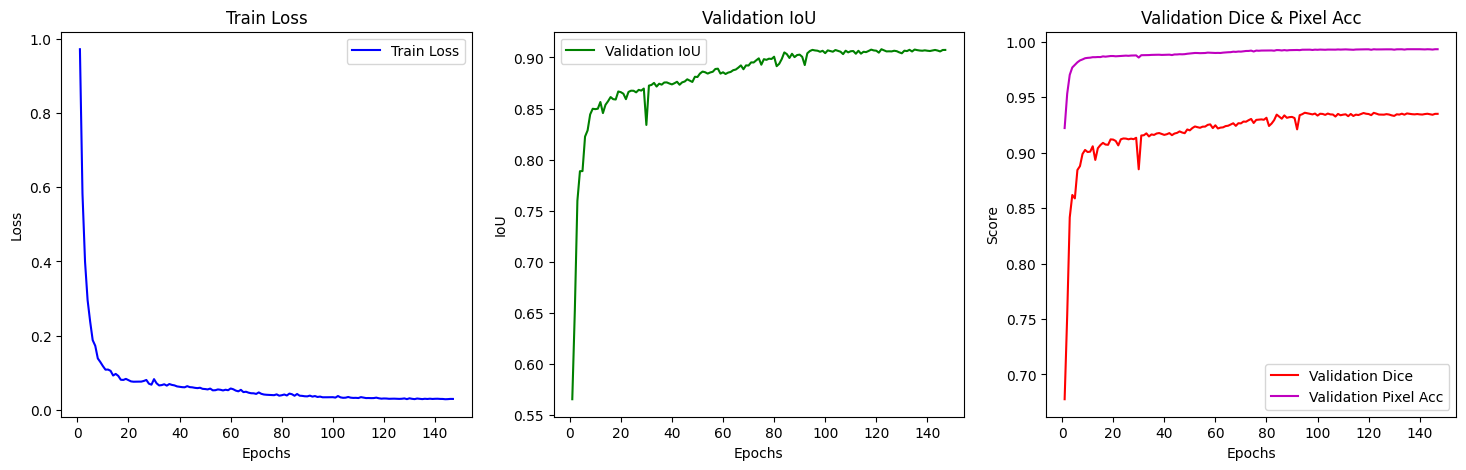

In [37]:
plot_training_history(history)


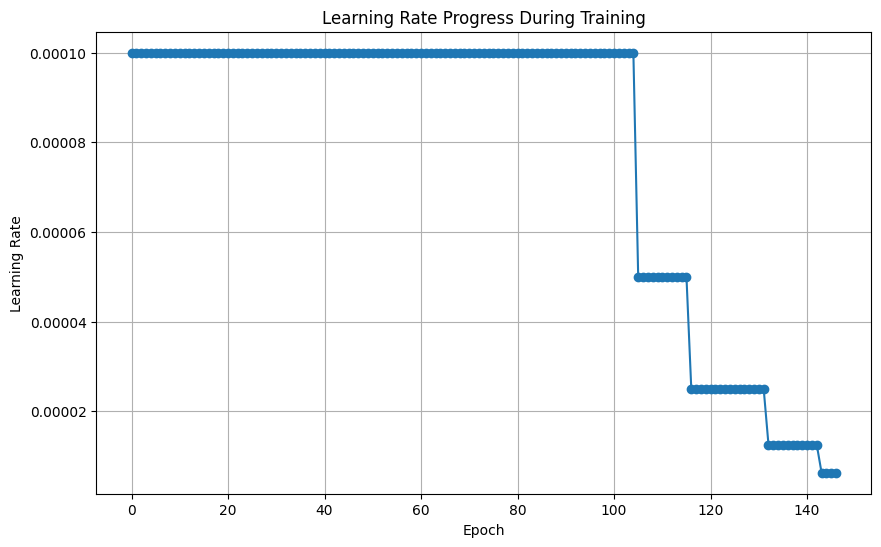

In [38]:
import matplotlib.pyplot as plt

# Plot Learning Rate vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(history["lr"], marker='o')
plt.title("Learning Rate Progress During Training")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


In [39]:
import os
import json
import pandas as pd

# Path penyimpanan di Google Drive
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new/02'

# Pastikan folder ada
os.makedirs(save_path, exist_ok=True)

# Save JSON
history_filename_json = os.path.join(save_path, 'training_history.json')
with open(history_filename_json, 'w') as f:
    json.dump(history, f)
print(f"✅ History JSON saved to {history_filename_json}")

# Save CSV
df_history = pd.DataFrame(history)
history_filename_csv = os.path.join(save_path, 'training_history.csv')
df_history.to_csv(history_filename_csv, index=False)
print(f"✅ History CSV saved to {history_filename_csv}")



✅ History JSON saved to /content/drive/MyDrive/colab_indra/ss/cwfid_new/02/training_history.json
✅ History CSV saved to /content/drive/MyDrive/colab_indra/ss/cwfid_new/02/training_history.csv


In [40]:
import os
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new/02'


os.makedirs(save_path, exist_ok=True)
# Path file
best_model_path = os.path.join(save_path, 'best_guru_model.pth')

# Save best model guru
torch.save(model.state_dict(), best_model_path)
print(f"✅ Model Guru Terbaik Disimpan di: {best_model_path}")


✅ Model Guru Terbaik Disimpan di: /content/drive/MyDrive/colab_indra/ss/cwfid_new/02/best_guru_model.pth


In [41]:
model.load_state_dict(torch.load('/content/drive/MyDrive/colab_indra/ss/cwfid_new/02/best_guru_model.pth'))
model.cuda()

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

# Fungsi Evaluasi Klasik

<ipython-input-31-396036164e16>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📊 Training Metrics:
Precision (macro): 0.9861
Recall (macro):    0.9787
F1-Score (macro):  0.9824
Confusion Matrix:
[[80233003    35235   109890]
 [   59889  1805172     1036]
 [  171378      769  5664012]]


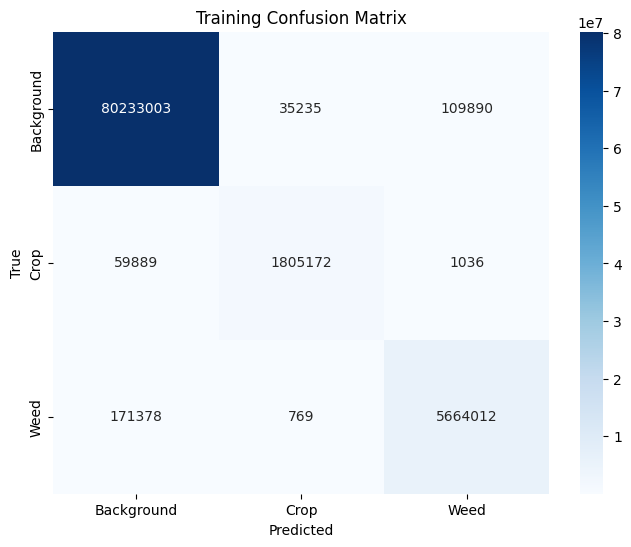

<ipython-input-31-396036164e16>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📊 Validation Metrics:
Precision (macro): 0.9660
Recall (macro):    0.9736
F1-Score (macro):  0.9697
Confusion Matrix:
[[22710516    19057    58948]
 [   15968   500152     4213]
 [   53331    15585  1788054]]


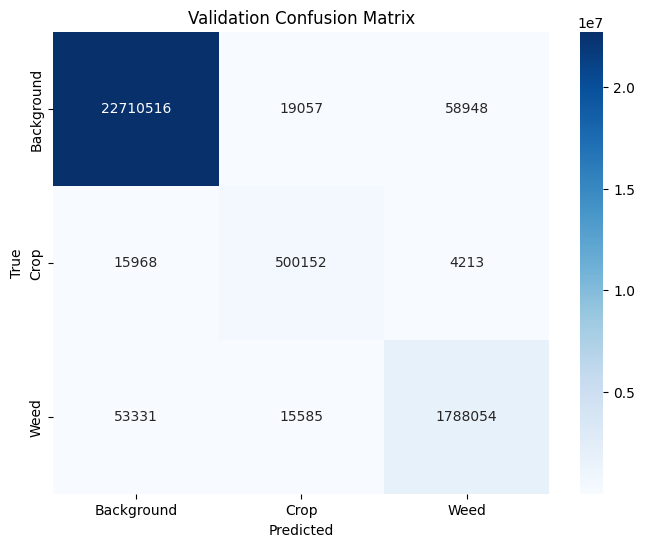

<ipython-input-31-396036164e16>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📊 Test Metrics:
Precision (macro): 0.9493
Recall (macro):    0.9650
F1-Score (macro):  0.9568
Confusion Matrix:
[[11655089    11201    23007]
 [    8126   195804     3022]
 [   19775    13385   653503]]


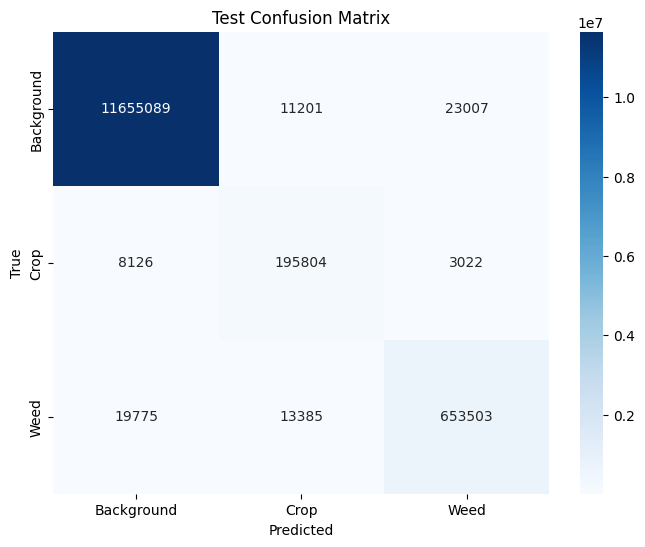

In [44]:
# Load model guru terbaik
#model.load_state_dict(torch.load('best_guru_model.pth'))
model.cuda()

# Nama kelas (optional buat plot)
class_names = ['Background', 'Crop', 'Weed']

# Evaluasi di training data
train_precision, train_recall, train_f1, train_cm = evaluate_metrics(
    model, train_loader, dataset_name='Training', class_names=class_names
)

# Evaluasi di validation data
val_precision, val_recall, val_f1, val_cm = evaluate_metrics(
    model, val_loader, dataset_name='Validation', class_names=class_names
)

# Evaluasi di test data
test_precision, test_recall, test_f1, test_cm = evaluate_metrics(
    model, test_loader,
    dataset_name='Test',
    class_names=class_names
)




```
📊 Training Metrics:
Precision (macro): 0.95
Recall (macro):    0.93
F1-Score (macro):  0.94
Confusion Matrix:
[[50000   100   200]
 [  150 12000   300]
 [  250   400  8000]]

📊 Validation Metrics:
Precision (macro): 0.88
Recall (macro):    0.85
F1-Score (macro):  0.86
Confusion Matrix:
[[49000   200   500]
 [  300 11000   500]
 [  400   800  7000]]
```




#Evaluasi Per Class

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_per_class_metrics(model, loader, class_names=None, num_classes=3):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with torch.amp.autocast('cuda'):
                outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Gabungkan semua batch
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Confusion Matrix (raw count)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Confusion Matrix (percent per row/class)
    cm_percent = cm.astype(np.float64)
    cm_percent = cm_percent / cm_percent.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 2)

    # Precision, Recall, F1-score per kelas
    precision = precision_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)

    # IoU per kelas
    iou_per_class = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class.append(iou)

    # Print Metrics Per Class
    print("Class-wise Metrics:\n")
    for cls in range(num_classes):
        class_name = class_names[cls] if class_names else f"Class {cls}"
        print(f"📌 {class_name}")
        print(f"Precision: {precision[cls]:.4f}")
        print(f"Recall   : {recall[cls]:.4f}")
        print(f"F1-Score : {f1[cls]:.4f}")
        print(f"IoU      : {iou_per_class[cls]:.4f}\n")

    # Plot Confusion Matrix (Percent)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%) per Class')
    plt.show()

    return precision, recall, f1, iou_per_class, cm_percent


Class-wise Metrics:

📌 Background
Precision: 0.9975
Recall   : 0.9982
F1-Score : 0.9978
IoU      : 0.9957

📌 Crop
Precision: 0.9805
Recall   : 0.9699
F1-Score : 0.9751
IoU      : 0.9515

📌 Weed
Precision: 0.9807
Recall   : 0.9747
F1-Score : 0.9777
IoU      : 0.9564



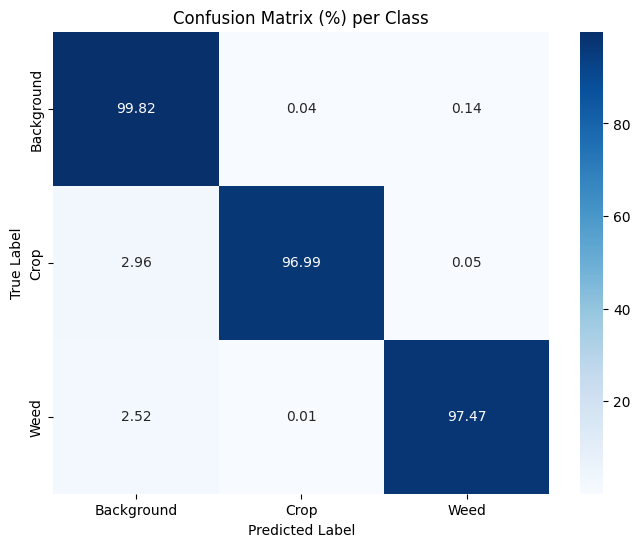

Class-wise Metrics:

📌 Background
Precision: 0.9970
Recall   : 0.9966
F1-Score : 0.9968
IoU      : 0.9936

📌 Crop
Precision: 0.9352
Recall   : 0.9612
F1-Score : 0.9480
IoU      : 0.9012

📌 Weed
Precision: 0.9659
Recall   : 0.9629
F1-Score : 0.9644
IoU      : 0.9312



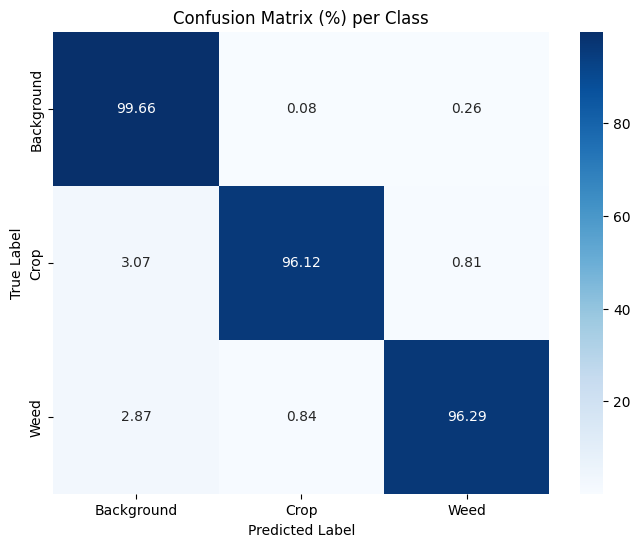

Class-wise Metrics:

📌 Background
Precision: 0.9976
Recall   : 0.9971
F1-Score : 0.9973
IoU      : 0.9947

📌 Crop
Precision: 0.8884
Recall   : 0.9461
F1-Score : 0.9164
IoU      : 0.8457

📌 Weed
Precision: 0.9617
Recall   : 0.9517
F1-Score : 0.9567
IoU      : 0.9170



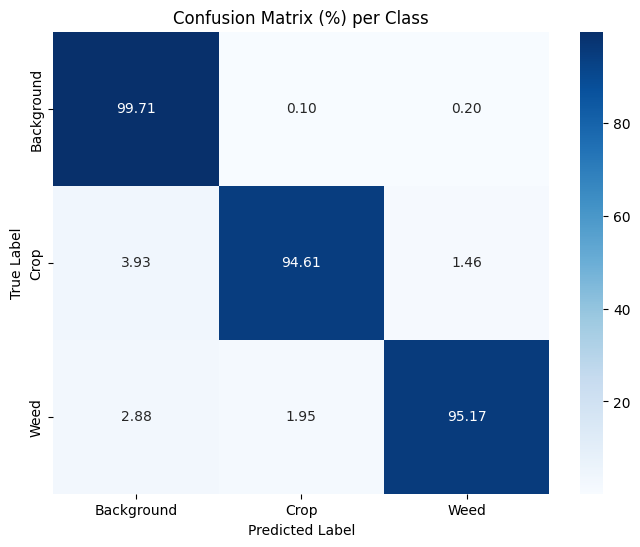

(array([0.99761183, 0.88844321, 0.9616957 ]),
 array([0.99707356, 0.94613244, 0.95170848]),
 array([0.99734262, 0.91638079, 0.95667602]),
 [np.float64(0.994699329993391),
  np.float64(0.8456668019932599),
  np.float64(0.9169500990608963)],
 array([[99.71,  0.1 ,  0.2 ],
        [ 3.93, 94.61,  1.46],
        [ 2.88,  1.95, 95.17]]))

In [46]:
class_names = ['Background', 'Crop', 'Weed']
evaluate_per_class_metrics(model, train_loader, class_names=class_names)
evaluate_per_class_metrics(model, val_loader, class_names=class_names)
evaluate_per_class_metrics(model, test_loader, class_names=class_names)


#Inferensi Full Image Dataset Asli

In [47]:
# Load best guru model
model.load_state_dict(torch.load('/content/drive/MyDrive/colab_indra/ss/cwfid_new/02/best_guru_model.pth'))
model.cuda()
model.eval()



DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

In [48]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [64]:
def infer_full_image(image_path, model, patch_size=512, stride=256, num_classes=3):
    # Load image asli
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Preprocessing sesuai train_transform Normalize (tanpa augmentasi)
    img_norm = (img_np / 255.0 - 0.5) / 0.5
    img_norm = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # B, C, H, W

    _, _, H, W = img_norm.shape

    # Prepare empty prediction mask
    pred_mask = torch.zeros((num_classes, H, W)).cuda()
    count_mask = torch.zeros((1, H, W)).cuda()

    # Hitung step posisi y dan x termasuk bagian border
    y_steps = list(range(0, H - patch_size + 1, stride))
    x_steps = list(range(0, W - patch_size + 1, stride))

    # Tambahin patch terakhir buat cover pinggir, kalau belum ke-cover
    if y_steps[-1] + patch_size < H:
        y_steps.append(H - patch_size)
    if x_steps[-1] + patch_size < W:
        x_steps.append(W - patch_size)

    # Sliding window inference (patching)
    for y in y_steps:
        for x in x_steps:
            patch = img_norm[:, :, y:y+patch_size, x:x+patch_size]

            with torch.amp.autocast('cuda'):
                output = model(patch)  # output shape: B, C, H, W

            pred_mask[:, y:y+patch_size, x:x+patch_size] += output.squeeze(0)
            count_mask[:, y:y+patch_size, x:x+patch_size] += 1

    # Normalisasi hasil prediksi
    pred_mask /= count_mask
    final_pred = torch.argmax(pred_mask, dim=0).cpu().numpy()

    return img_np, final_pred


In [65]:
def evaluate_single_image(pred_mask, gt_mask, num_classes=3, class_names=None):
    # Flatten mask untuk perhitungan metric
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion Matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))

    # Precision, Recall, F1-score per kelas
    precision = precision_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)

    # IoU per kelas
    iou_per_class = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class.append(iou)

    # Tampilkan metrik
    print("📊 Per-Class Evaluation Metrics:")
    for cls in range(num_classes):
        name = class_names[cls] if class_names else f"Class {cls}"
        print(f"{name} | Precision: {precision[cls]:.4f}, Recall: {recall[cls]:.4f}, F1: {f1[cls]:.4f}, IoU: {iou_per_class[cls]:.4f}")

    return precision, recall, f1, iou_per_class, cm


In [66]:
def visualize_full_prediction(img_np, pred_mask, gt_mask=None, class_colors=None, alpha=0.4, class_names=None):
    H, W, _ = img_np.shape

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    # Buat color mask dari prediksi
    color_pred_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for cls, color in class_colors.items():
        color_pred_mask[pred_mask == cls] = color

    # Overlay prediksi di gambar asli
    overlay_pred = (1 - alpha) * img_np / 255.0 + alpha * color_pred_mask / 255.0
    overlay_pred = np.clip(overlay_pred, 0, 1)

    # Buat color mask dari ground truth (jika ada)
    if gt_mask is not None:
        color_gt_mask = np.zeros((H, W, 3), dtype=np.uint8)
        for cls, color in class_colors.items():
            color_gt_mask[gt_mask == cls] = color
    else:
        color_gt_mask = np.zeros((H, W, 3), dtype=np.uint8)

    # Plot visualisasi
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(color_gt_mask)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_pred)
    plt.title("Overlay Prediction")
    plt.axis('off')

    plt.show()

    # ✅ Evaluasi metrik setelah visualisasi
    if gt_mask is not None:
        precision, recall, f1, iou_per_class, cm = evaluate_single_image(pred_mask, gt_mask, num_classes=len(class_colors), class_names=class_names)
        return precision, recall, f1, iou_per_class, cm
    else:
        print("⚠️ Ground truth mask not provided, skipping metrics evaluation.")
        return None


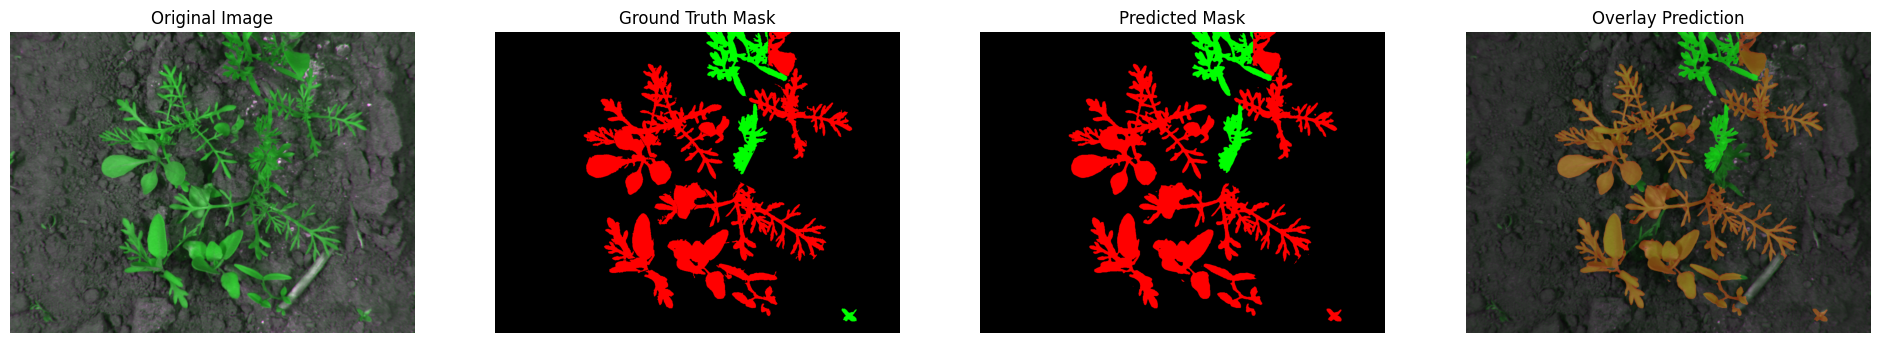

📊 Per-Class Evaluation Metrics:
Background | Precision: 0.9942, Recall: 0.9958, F1: 0.9950, IoU: 0.9900
Crop | Precision: 0.9821, Recall: 0.9299, F1: 0.9553, IoU: 0.9145
Weed | Precision: 0.9709, Recall: 0.9702, F1: 0.9706, IoU: 0.9428


In [70]:
image_path = '/content/dataset-1.0/images/001_image.png'
gt_mask_path = '/content/dataset-1.0/annotations/001_annotation.png'

# Load ground truth mask
gt_mask_rgb = Image.open(gt_mask_path).convert("RGB")
gt_mask_np = np.array(gt_mask_rgb)

# Convert RGB mask ke label mask
gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

# Inference gambar
img_np, pred_mask = infer_full_image(
    image_path=image_path,
    model=model,
    patch_size=512,
    stride=256,
    num_classes=3
)

# Visualisasi + evaluasi
class_names = ['Background', 'Crop', 'Weed']

precision, recall, f1, iou, cm = visualize_full_prediction(
    img_np, pred_mask, gt_mask=gt_label_mask, class_names=class_names
)


In [73]:
import random
import os
from PIL import Image
import numpy as np

# Path dataset
image_dir = '/content/dataset-1.0/images/'
gt_mask_dir = '/content/dataset-1.0/annotations/'

# Ambil semua file di folder gambar (filter png)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Random sampling 5 file
random_images = random.sample(image_files, 5)

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Loop 5 sample
for idx, img_file in enumerate(random_images):
    print(f"\n🔎 Sample {idx+1}: {img_file}")

    # Path image dan ground truth mask
    image_path = os.path.join(image_dir, img_file)

    # Sesuaikan nama mask (replace image jadi annotation kalau beda)
    gt_mask_file = img_file.replace('image', 'annotation')  # <== Penyesuaian!
    gt_mask_path = os.path.join(gt_mask_dir, gt_mask_file)

    # Load ground truth mask
    gt_mask_rgb = Image.open(gt_mask_path).convert("RGB")
    gt_mask_np = np.array(gt_mask_rgb)

    # Convert RGB mask ke label mask
    gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

    # Inference gambar
    img_np, pred_mask = infer_full_image(
        image_path=image_path,
        model=model,
        patch_size=512,
        stride=256,
        num_classes=3
    )

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_np, pred_mask, gt_mask=gt_label_mask, class_names=class_names
    )

    # Optional: print metrics simple
    print(f"✅ Finished sample {idx+1}")


Output hidden; open in https://colab.research.google.com to view.

#test pada test dataset

In [76]:
def infer_from_array(image_array, model, patch_size=512, stride=256, num_classes=3):
    # Convert array (H, W, C) ➡️ Tensor dan normalisasi (sama kayak training!)
    img_norm = (image_array / 255.0 - 0.5) / 0.5
    img_norm = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # B, C, H, W

    _, _, H, W = img_norm.shape

    # Prepare empty prediction mask
    pred_mask = torch.zeros((num_classes, H, W)).cuda()
    count_mask = torch.zeros((1, H, W)).cuda()

    # Hitung langkah patch
    y_steps = list(range(0, H - patch_size + 1, stride))
    x_steps = list(range(0, W - patch_size + 1, stride))

    if y_steps[-1] + patch_size < H:
        y_steps.append(H - patch_size)
    if x_steps[-1] + patch_size < W:
        x_steps.append(W - patch_size)

    # Sliding window inference
    for y in y_steps:
        for x in x_steps:
            patch = img_norm[:, :, y:y+patch_size, x:x+patch_size]

            with torch.amp.autocast('cuda'):
                output = model(patch)

            pred_mask[:, y:y+patch_size, x:x+patch_size] += output.squeeze(0)
            count_mask[:, y:y+patch_size, x:x+patch_size] += 1

    # Normalisasi hasil prediksi
    pred_mask /= count_mask
    final_pred = torch.argmax(pred_mask, dim=0).cpu().numpy()

    return final_pred


In [77]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Asumsi test_dataset return: image, label_mask
# Kalau custom dataset lo return tuple lain ➡️ sesuaikan ya bro!

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Ambil 5 index random dari test_dataset
random_indices = random.sample(range(len(test_dataset)), 5)

for idx, sample_idx in enumerate(random_indices):
    print(f"\n🔎 Test Sample {idx+1} | Dataset index: {sample_idx}")

    # Ambil data sample dari test_dataset
    image_tensor, gt_label_mask = test_dataset[sample_idx]

    # Convert image_tensor (C, H, W) ➡️ numpy (H, W, C)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Denormalisasi image kalau sebelumnya dinormalisasi
    img_np = (img_np * 0.5 + 0.5) * 255  # Sesuai normalisasi training lo!
    img_np = img_np.astype(np.uint8)

    # Inference ➡️ langsung dari image_tensor atau dari img_np
    # Kalau infer_full_image butuh path ➡️ kita bikin versi infer_from_array!
    pred_mask = infer_from_array(
        image_array=img_np,
        model=model,
        patch_size=512,
        stride=256,
        num_classes=3
    )

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_np, pred_mask, gt_mask=gt_label_mask.cpu().numpy(), class_names=class_names
    )

    print(f"✅ Finished test sample {idx+1}")


Output hidden; open in https://colab.research.google.com to view.

In [54]:
import time
import torch

def measure_inference_time(model, input_size=(1, 3, 512, 512), num_runs=100, device='cuda'):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)

    # Warm-up GPU (biar gak kena cold start)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Start timing
    torch.cuda.synchronize()  # pastikan semua proses selesai (untuk GPU)
    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)

    torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_run = total_time / num_runs

    print(f"🔥 Inference time per image ({input_size[-2]}x{input_size[-1]}): {avg_time_per_run*1000:.2f} ms")
    print(f"⚡ FPS (Frames Per Second): {1.0 / avg_time_per_run:.2f}")

    return avg_time_per_run


In [55]:
import torch

if torch.cuda.is_available():
    gpu_idx = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_idx)
    gpu_capability = torch.cuda.get_device_capability(gpu_idx)
    gpu_mem = torch.cuda.get_device_properties(gpu_idx).total_memory / 1024**3

    print(f"🖥️ GPU Name         : {gpu_name}")
    print(f"🛠️ Compute Capability : {gpu_capability}")
    print(f"💾 Total VRAM        : {gpu_mem:.2f} GB")
else:
    print("⚠️ CUDA not available. Using CPU.")


🖥️ GPU Name         : Tesla T4
🛠️ Compute Capability : (7, 5)
💾 Total VRAM        : 14.74 GB


In [56]:
!nvidia-smi


Wed Mar 19 11:22:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             34W /   70W |    7382MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [57]:
# Pastikan model di GPU/CPU
model.cuda()  # atau model.cpu() kalau mau test CPU

# Ukur waktu inferensi, contoh input 512x512, 100 kali loop
measure_inference_time(model, input_size=(1, 3, 512, 512), num_runs=100, device='cuda')


🔥 Inference time per image (512x512): 38.13 ms
⚡ FPS (Frames Per Second): 26.23


0.03812921524047851

In [58]:
import time

start_time = time.time()

img_np, pred_mask = infer_full_image(
    image_path=image_path,
    model=model,
    patch_size=512,
    stride=256,
    num_classes=3
)

end_time = time.time()
total_time = end_time - start_time

print(f"🔥 Inference time per full image: {total_time:.3f} sec")
print(f"⚡ FPS (full image): {1.0 / total_time:.2f}")


🔥 Inference time per full image: 0.384 sec
⚡ FPS (full image): 2.60


#Evaluasi Head-to-Head Style McCool

In [59]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def evaluate_mccool_metrics(pred_mask, gt_mask, num_classes=3, class_names=None):
    # Flatten buat metric calculation
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion Matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))

    # Overall Pixel-wise Accuracy
    overall_acc = np.sum(np.diag(cm)) / np.sum(cm)

    # Per-class Precision & Recall
    precision = precision_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)

    # FPR & FNR per class
    fpr = []
    fnr = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fn = cm[cls, :].sum() - tp
        fp = cm[:, cls].sum() - tp
        tn = np.sum(cm) - (tp + fp + fn)

        fpr_cls = fp / (fp + tn + 1e-7)
        fnr_cls = fn / (fn + tp + 1e-7)

        fpr.append(fpr_cls)
        fnr.append(fnr_cls)

    # Tampilkan Hasil
    print(f"======================== McCool Style Metrics ========================")
    print(f"Overall Pixel-wise Accuracy (ACC): {overall_acc:.4f}")

    for cls in range(num_classes):
        name = class_names[cls] if class_names else f"Class {cls}"
        print(f"\n📌 {name}")
        print(f"Precision: {precision[cls]:.4f}")
        print(f"Recall   : {recall[cls]:.4f}")
        print(f"FPR      : {fpr[cls]*100:.2f}%")
        print(f"FNR      : {fnr[cls]*100:.2f}%")

    return overall_acc, precision, recall, fpr, fnr


In [60]:
def evaluate_dataset_mccool(model, loader, dataset_name='Dataset', class_names=None, num_classes=3):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with torch.amp.autocast('cuda'):
                outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Gabungkan semua prediksi dan ground truth
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    print(f"\n====================== {dataset_name} ======================")
    return evaluate_mccool_metrics(all_preds, all_masks, num_classes=num_classes, class_names=class_names)


In [61]:
# Pastikan class_names sesuai dataset
class_names = ['Background', 'Crop', 'Weed']

# Train
evaluate_dataset_mccool(model, train_loader, dataset_name='TRAIN', class_names=class_names)

# Validation
evaluate_dataset_mccool(model, val_loader, dataset_name='VALIDATION', class_names=class_names)

# Test
evaluate_dataset_mccool(model, test_loader, dataset_name='TEST', class_names=class_names)



====================== TRAIN ======================
======================== McCool Style Metrics ========================
Overall Pixel-wise Accuracy (ACC): 0.9959

📌 Background
Precision: 0.9974
Recall   : 0.9982
FPR      : 2.77%
FNR      : 0.18%

📌 Crop
Precision: 0.9804
Recall   : 0.9676
FPR      : 0.04%
FNR      : 3.24%

📌 Weed
Precision: 0.9805
Recall   : 0.9736
FPR      : 0.14%
FNR      : 2.64%

====================== VALIDATION ======================
======================== McCool Style Metrics ========================
Overall Pixel-wise Accuracy (ACC): 0.9934

📌 Background
Precision: 0.9970
Recall   : 0.9966
FPR      : 2.92%
FNR      : 0.34%

📌 Crop
Precision: 0.9352
Recall   : 0.9612
FPR      : 0.14%
FNR      : 3.88%

📌 Weed
Precision: 0.9659
Recall   : 0.9629
FPR      : 0.27%
FNR      : 3.71%

====================== TEST ======================
======================== McCool Style Metrics ========================
Overall Pixel-wise Accuracy (ACC): 0.9938

📌 Background
Prec

(np.float64(0.9937601089477539),
 array([0.99761183, 0.88844321, 0.9616957 ]),
 array([0.99707356, 0.94613244, 0.95170848]),
 [np.float64(0.031222618241633006),
  np.float64(0.0019865933632623087),
  np.float64(0.0021880006042240526)],
 [np.float64(0.0029264377489937768),
  np.float64(0.05386756349295785),
  np.float64(0.04829152000325512)])

#tes langsung 512x512 tanpa patch

 Random ➡️ Resize ➡️ Inference ➡️ Visualisasi

In [78]:
import random
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path dataset asli
image_dir = '/content/dataset-1.0/images/'
gt_mask_dir = '/content/dataset-1.0/annotations/'

# Ambil semua file gambar
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Ambil 5 gambar random
random_images = random.sample(image_files, 5)

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Model ke eval mode
model.eval()

for idx, img_file in enumerate(random_images):
    print(f"\n🔎 Sample {idx+1}: {img_file}")

    # Load image
    image_path = os.path.join(image_dir, img_file)
    img = Image.open(image_path).convert("RGB")

    # Resize ke 512x512
    img_resized = img.resize((512, 512))
    img_np = np.array(img_resized)

    # Normalisasi (sesuai training transform lo)
    img_norm = (img_np / 255.0 - 0.5) / 0.5
    img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # [1, C, 512, 512]

    # Ground truth mask
    gt_mask_file = img_file.replace('image', 'annotation')  # Pastikan sesuai nama mask lo!
    gt_mask_path = os.path.join(gt_mask_dir, gt_mask_file)
    gt_mask = Image.open(gt_mask_path).convert("RGB")
    gt_mask_resized = gt_mask.resize((512, 512))  # Resize mask juga!
    gt_mask_np = np.array(gt_mask_resized)

    # Convert RGB mask ke label mask
    gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

    # Inference
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            output = model(img_tensor)

    pred_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()

    # Convert image_tensor buat visualisasi
    img_vis = (img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255
    img_vis = img_vis.astype(np.uint8)

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_vis, pred_mask, gt_mask=gt_label_mask, class_names=class_names
    )

    print(f"✅ Finished sample {idx+1}")


Output hidden; open in https://colab.research.google.com to view.